Dataset from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

# CNN Model on Chest X-Ray Pneumonia

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 2
img_rows, img_cols = 224, 224
batch_size = 16

In [3]:
train_data_dir = 'chest_xray/train'
validation_data_dir = 'chest_xray/test'

In [4]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

In [5]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='binary')

Found 5216 images belonging to 2 classes.


In [7]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='binary')

Found 624 images belonging to 2 classes.


## CNN Model

In [8]:
def cnn():
    model = Sequential([
   #Convolution
    Conv2D(32, (3, 3), activation="relu", input_shape=(img_rows, img_cols, 3)),
    #Pooling
    MaxPooling2D(pool_size = (2, 2)),
    # 2nd Convolution
    Conv2D(32, (3, 3), activation="relu"),
    # 2nd Pooling layer
    MaxPooling2D(pool_size = (2, 2)),
    # Flatten the laye,
    Flatten(),
    # Fully Connected Layers
    Dense(128,activation = 'relu'),
    Dense(1,activation = 'sigmoid'),
    ])
    return model

In [9]:
model = cnn()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               11944064  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total para

### Training CNN Model

In [10]:
checkpoint = ModelCheckpoint("chest_xray_cnn1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

callbacks = [earlystop, checkpoint, reduce_lr]

In [11]:
model.compile(loss = 'binary_crossentropy',
              optimizer = "adam",
              metrics = ['accuracy'])

In [12]:
nb_train_samples = 5216
nb_validation_samples = 624
epochs = 15

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/15
326/326 [==============================] - 360s 1s/step - loss: 0.4254 - acc: 0.7914 - val_loss: 0.7091 - val_acc: 0.6282

Epoch 00001: val_loss improved from inf to 0.70909, saving model to chest_xray_cnn1.h5
Epoch 2/15
326/326 [==============================] - 285s 876ms/step - loss: 0.3752 - acc: 0.8173 - val_loss: 0.5097 - val_acc: 0.7244

Epoch 00002: val_loss improved from 0.70909 to 0.50969, saving model to chest_xray_cnn1.h5
Epoch 3/15
326/326 [==============================] - 289s 886ms/step - loss: 0.3545 - acc: 0.8405 - val_loss: 0.4000 - val_acc: 0.8397

Epoch 00003: val_loss improved from 0.50969 to 0.40005, saving model to chest_xray_cnn1.h5
Epoch 4/15
326/326 [==============================] - 290s 891ms/step - loss: 0.3347 - acc: 0.8439 - val_loss: 0.4876 - val_acc: 0.7468

Epoch 00004: val_loss did not improve from 0.40005
Epoch 5/15
326/326 [==============================] - 292s 897ms/step - loss: 0.3143 - acc: 0.8599 - val_loss: 0.4183 - val_acc: 0.8093

In [14]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

39/39 [==============================] - 18s 469ms/step

Test result: 83.173 loss: 0.358


In [15]:
model.save("chest_xray_cnn.h5")

## Confusion Matrix 

In [16]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 624 images belonging to 2 classes.


In [17]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

In [18]:
classes

['NORMAL', 'PNEUMONIA']

In [19]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size)

In [20]:
y_pred =(y_pred>0.5)

In [21]:
#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=classes))

Confusion Matrix
[[153  81]
 [ 27 363]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.85      0.65      0.74       234
   PNEUMONIA       0.82      0.93      0.87       390

   micro avg       0.83      0.83      0.83       624
   macro avg       0.83      0.79      0.80       624
weighted avg       0.83      0.83      0.82       624



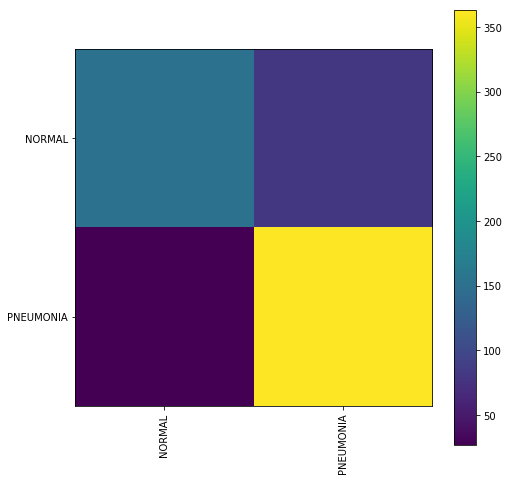

In [22]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

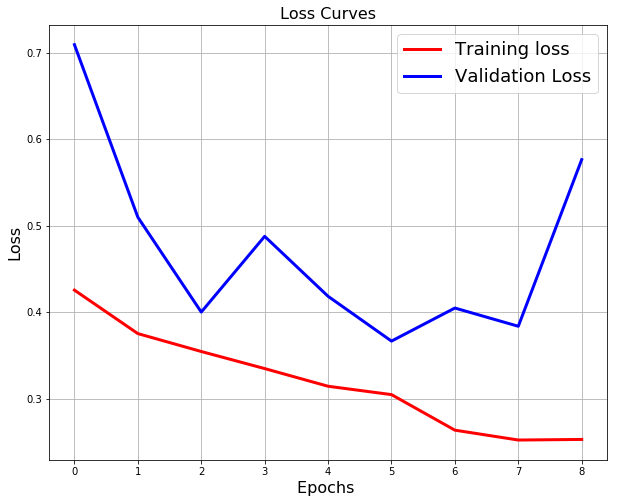

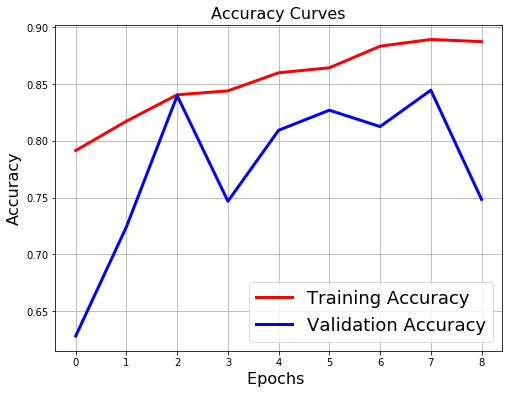

In [23]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16);

### Loading saved classifier

In [24]:
classifier = load_model('chest_xray_cnn.h5')

## Testing on Images

In [25]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers.advanced_activations import ELU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)
    

def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 10):
    path = 'chest_xray/val/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, (img_width, img_height), fx=5, fy=5, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

<img src="Chest X-Ray Pneumonia-CNN.png">

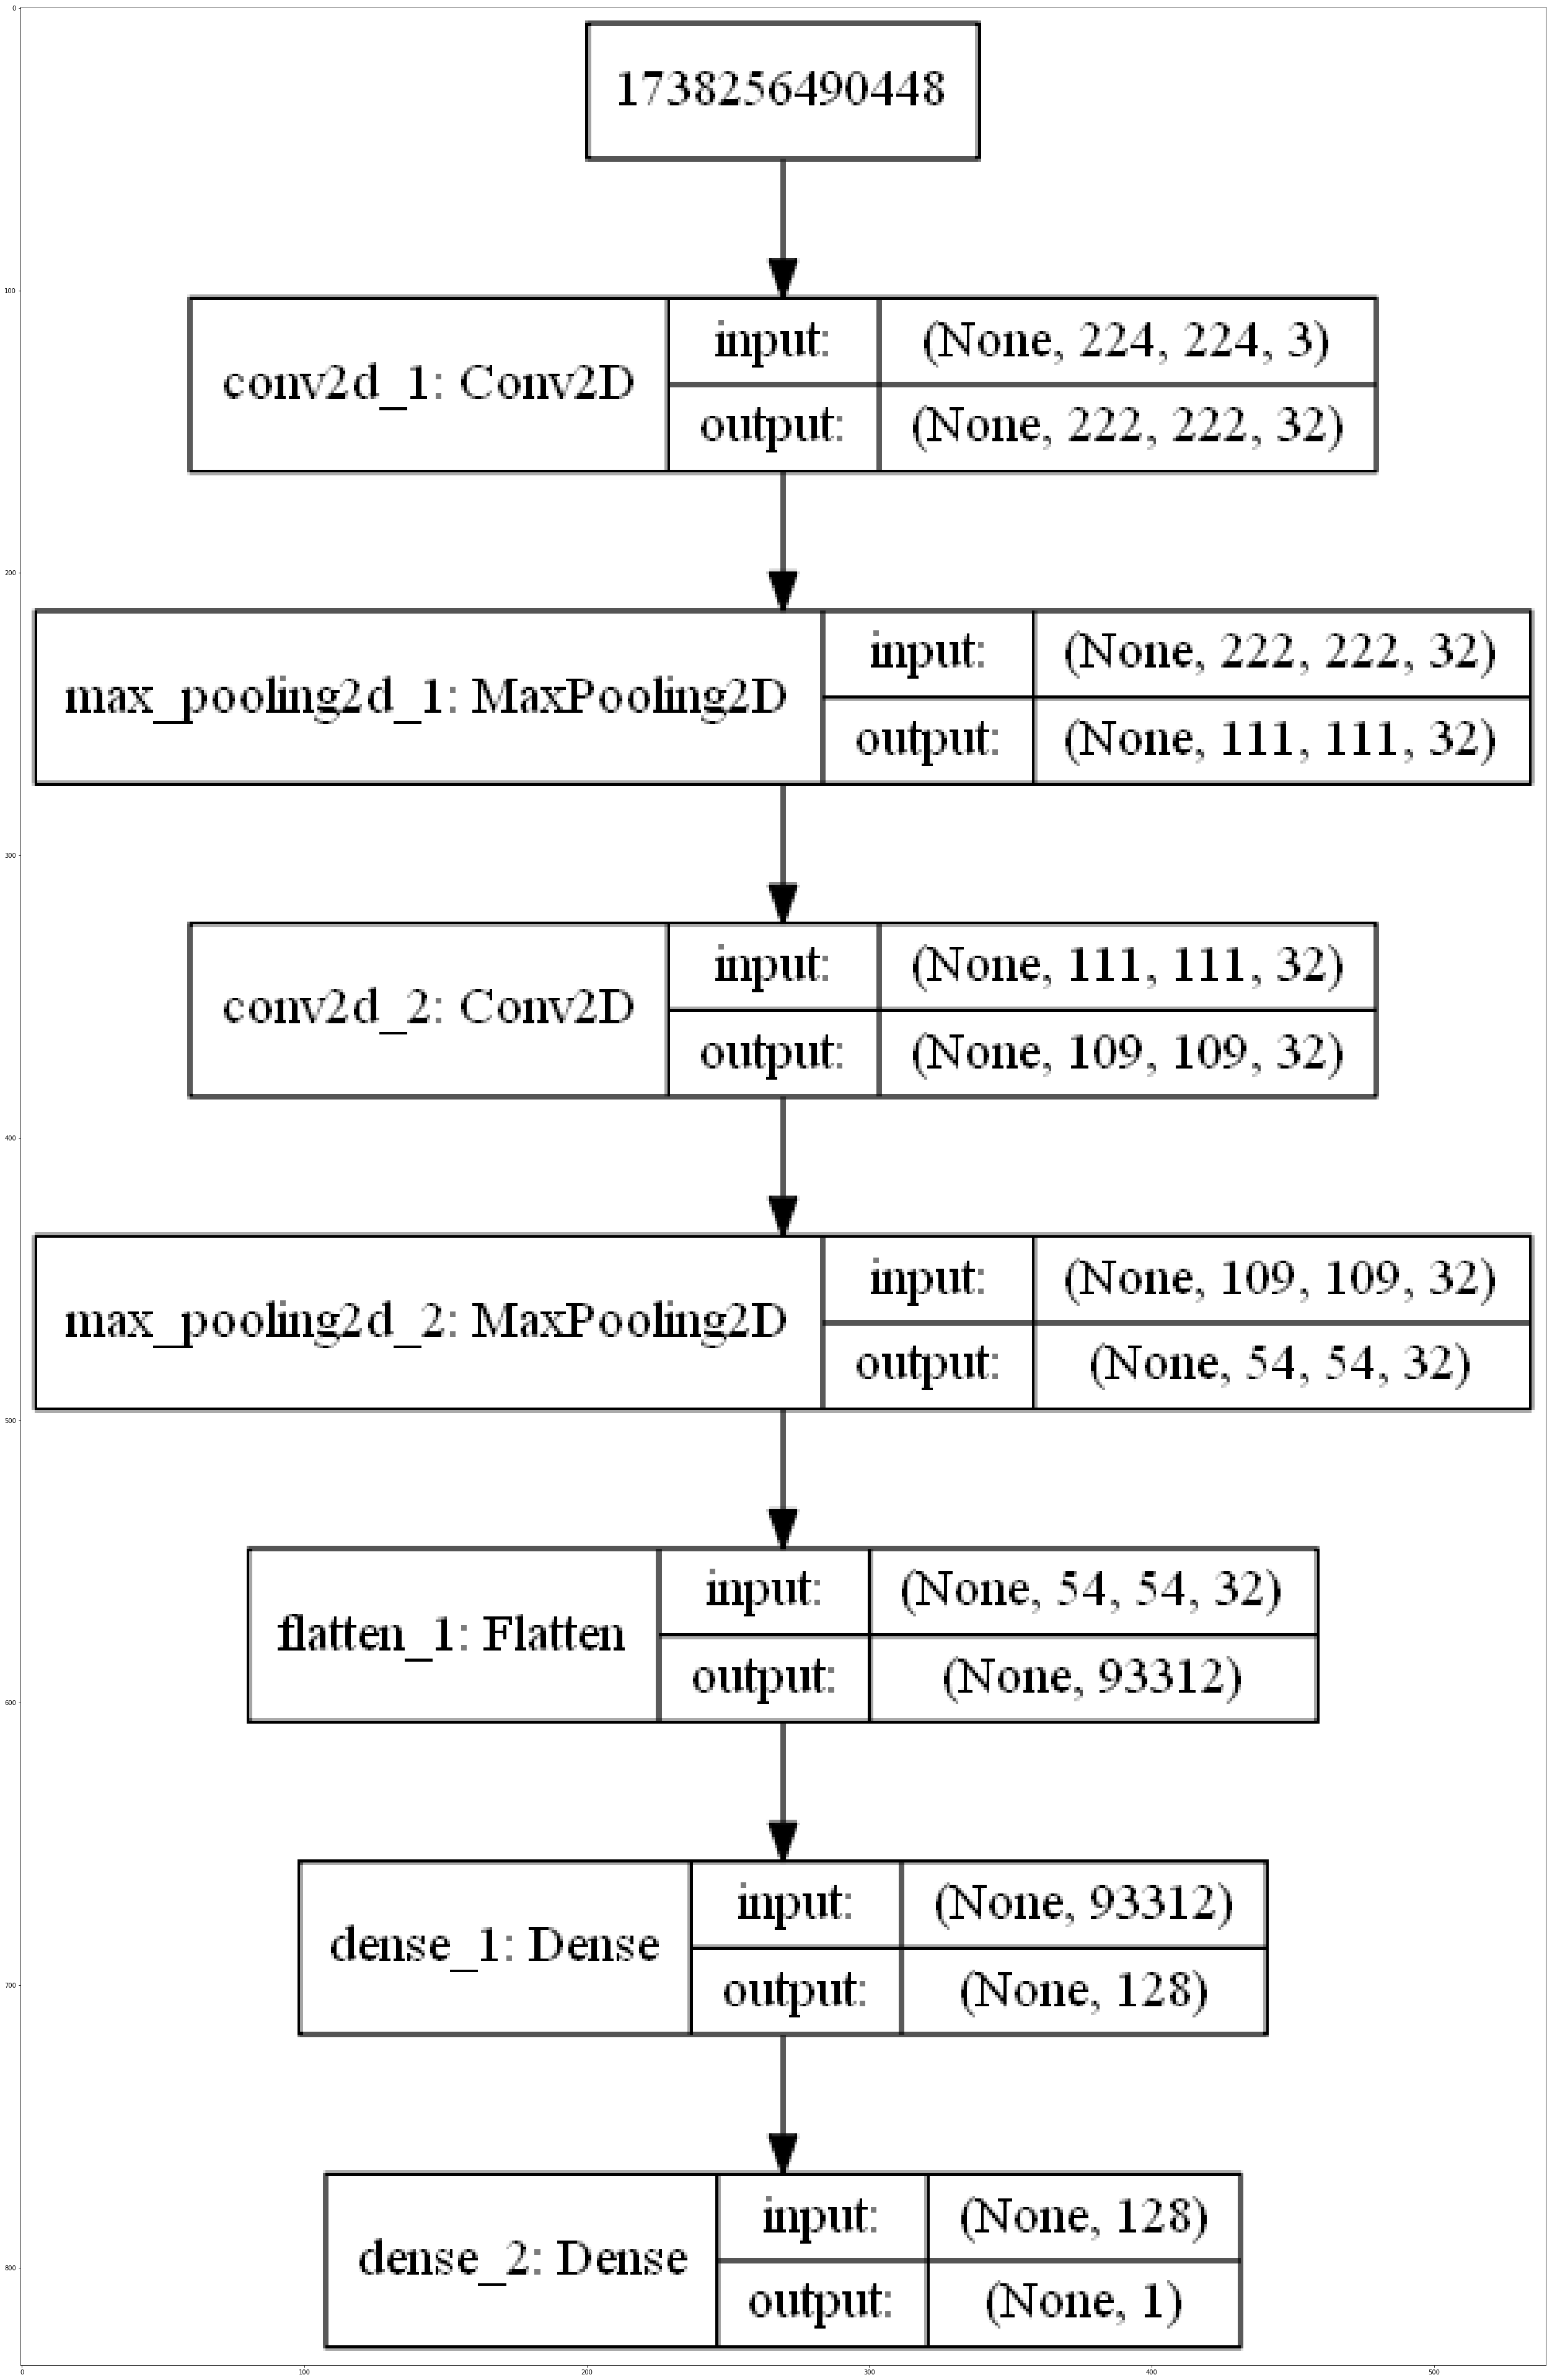

In [26]:
plot_model(model, to_file='model_plot_chest_xray_cnn.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('model_plot_chest_xray_cnn.png')
plt.figure(figsize=(100,70))
imgplot = plt.imshow(img)